# CBIR CON HISTOGRAMA DE TEXTURAS

In [14]:
import cv2
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import random

In [15]:
n_imgs = 100
carpetas = ["autobus-n04487081", "clavos-n03804744", "coche-n02814533", "collarin-n03814639", "desatascador-n03970156",
         "gatos-n02123394", "mono-n02480495", "puentes-n04532670", "silla-n04099969", "perro-n02099601", 
            "pato-n01855672", "pizza-n07873807", "mar-n09428293", "ipod-n03584254", "platano-n07753592", "mascara_gas-n03424325", 
            "pajarita-n02883205", "mosca-n02190166", "helado-n07615774", "canon-n02950826"]
len(carpetas)

20

In [16]:
def get_images_path(carpetas, n_imgs):
    images_path = {}
    for carpeta in carpetas:
        for i in range(n_imgs):
            images_path[(carpeta[-7:], str(i))] = f'./dataset/{carpeta}/{carpeta[-9:]}_{str(i)}.JPEG'
    return images_path #Devuelve un diccionario en el que la clave es (carpeta, id), y los valores los paths

In [17]:
images_path = get_images_path(carpetas, n_imgs)
len(images_path)

2000

In [18]:
def calculate_texture_histogram(image, bins=8):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    histograms = []

    for i in range(bins):
        lower_bound = i * (256 // bins)
        upper_bound = (i + 1) * (256 // bins)
        mask = cv2.inRange(gray_image, lower_bound, upper_bound)
        hist = cv2.calcHist([gray_image], [0], mask, [8], [0, 256])
        histograms.append(hist)

    histogram = np.concatenate(histograms)
    histogram = cv2.normalize(histogram, None).flatten()

    return histogram

In [30]:
histograma_1 = calculate_texture_histogram(cv2.imread(list(images_path.values())[0]))
histograma_1

array([0.21462081, 0.00734229, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.3959189 ,
       0.01581416, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.49532226, 0.01920291,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.6320018 , 0.02654521, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.36033705, 0.00790708, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.13329083, 0.00282396, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.04235937,
       0.00112958, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.03953541], dtype=float32)

In [31]:
len(histograma_1)

64

In [23]:
texture_histograms = []  # Usaremos una lista en lugar de un array numpy

# Asumiendo que estás usando 8 bins
desired_length = 64

for idx in images_path:
    im = cv2.imread(images_path[idx])
    histogram = calculate_texture_histogram(im)
    histograms_arr = np.array(histogram)
    
    # Verifica y ajusta la longitud si es necesario
    if histograms_arr.shape[0] != desired_length:
        # Rellena con ceros para que todos los histogramas tengan la misma longitud
        zeros_to_add = desired_length - histograms_arr.shape[0]
        histograms_arr = np.concatenate((histograms_arr, np.zeros(zeros_to_add)))
    
    # Agrega el histograma a la lista
    histograms_arr = np.insert(histograms_arr, 0, idx[1])
    histograms_arr = np.insert(histograms_arr, 0, idx[0])
    texture_histograms.append(histograms_arr)

# Convierte la lista de histogramas en un array numpy
texture_histograms = np.array(texture_histograms)

In [24]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='euclidean')

texture_histograms_train = texture_histograms[:, 2:] #Quitamos los dos primeros pertenecientes a indices de la imagen
knn.fit(texture_histograms_train)

NearestNeighbors(metric='euclidean')

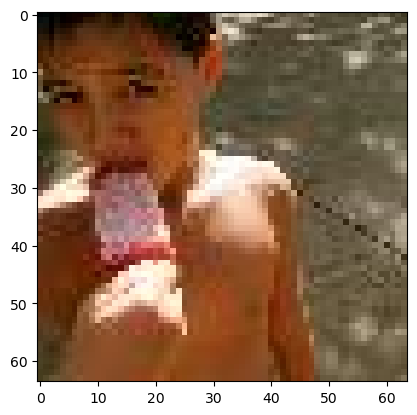

In [28]:
new_image_path = list(images_path.values())[random.randrange(0, len(carpetas)*n_imgs - 1)]
new_img = cv2.imread(new_image_path)
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))

# Calcular el histograma de la nueva imagen
new_histogram = calculate_texture_histogram(new_img)
histogram_flat = new_histogram.reshape(1, -1)
distance, indice = knn.kneighbors(histogram_flat, n_neighbors=5)


idx_dist = list(zip(indice[0], distance[0]))
idx_dist = [tupla[0] for tupla in sorted(idx_dist, key=lambda x: x[1])]
ids = []
for idx in idx_dist:
        carpeta = str(int(texture_histograms[idx,0]))
        num_img = str(int(texture_histograms[idx,1]))
        ids.append((carpeta, num_img))

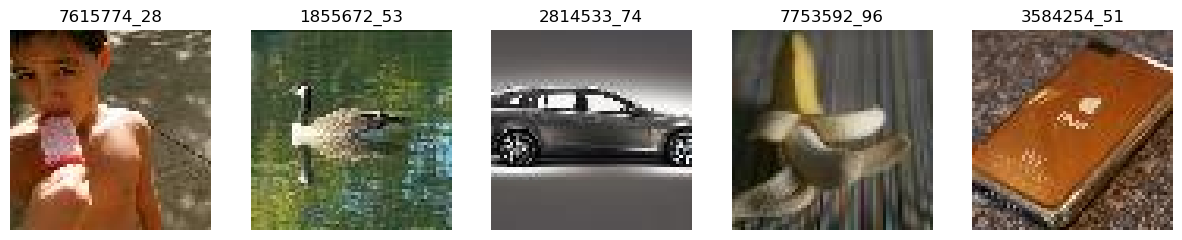

In [29]:
def display_n_similar(sorted_indexes, n):
    if n <= 0:
        print("El valor de n debe ser mayor que 0.")
        return

    if n > len(sorted_indexes):
        print(f"Solo hay {len(sorted_indexes)} imágenes en la lista. Mostrando todas.")
        n = len(sorted_indexes)
    fig, axs = plt.subplots(1, n, figsize=(15,15))
    for i in range(n):
        n_carpeta = (sorted_indexes[i][0])
        n_img = (sorted_indexes[i][1])
        path = images_path[(n_carpeta, n_img)]
        im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        axs[i].imshow(im)
        axs[i].axis('off')
        titulo = f'{n_carpeta}_{n_img}'
        axs[i].set_title(titulo)
        
    plt.show()
display_n_similar(ids, 5)